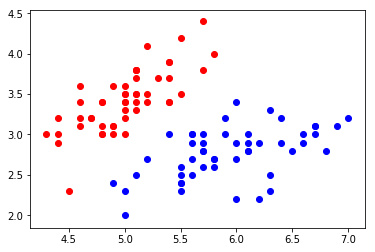

In [107]:
import numpy as np 
from numpy import *
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
iris = datasets.load_iris()
X = iris.data
y = iris.target
X = X[y<2, :2]
y = y[y<2]

plt.scatter(X[y==0, 0], X[y==0, 1], color='red')
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue')
plt.show()


X_train, X_test, y_train, y_test = train_test_split(X, y)

### 注意 AdaBoost 标签数据 是+1 和-1， 而非1和0

In [166]:
y_test[y_test==0] = -1
y_train[y_train==0] = -1
y_train

array([-1, -1,  1, -1,  1,  1,  1,  1, -1,  1, -1, -1,  1, -1,  1, -1, -1,
       -1, -1,  1,  1, -1,  1, -1, -1, -1, -1, -1,  1, -1,  1,  1, -1,  1,
       -1, -1, -1,  1,  1, -1,  1, -1, -1,  1, -1, -1, -1,  1,  1,  1,  1,
       -1,  1,  1,  1, -1, -1, -1,  1, -1,  1,  1, -1, -1,  1,  1,  1, -1,
       -1, -1,  1,  1, -1, -1, -1])

### 测试方法

In [4]:
def loadSimpData():
    dataMat = np.matrix([
        [1. , 2.1],
        [2. , 1.1],
        [1.3, 1.],
        [1. , 1. ],
        [2. , 1.]
    ])
    
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    
    return dataMat, classLabels

In [43]:
dataMat, classLabels = loadSimpData()

In [44]:
classLabels

[1.0, 1.0, -1.0, -1.0, 1.0]

In [45]:
def stumpClassify(dataMatrix, dimen, threshVal, threshIneq):
    retArray = np.ones((np.shape(dataMatrix)[0] , 1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:, dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:, dimen] > threshVal] = -1.0
    return retArray


In [46]:
def buildStump(dataArr,classLabels,D):
    dataMatrix = mat(dataArr); labelMat = mat(classLabels).T
    m,n = shape(dataMatrix)
    numSteps = 10.0; bestStump = {}; bestClasEst = mat(zeros((m,1)))
    minError = inf #init error sum, to +infinity
    for i in range(n):#loop over all dimensions
        rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max();
        stepSize = (rangeMax-rangeMin)/numSteps
        for j in range(-1,int(numSteps)+1):#loop over all range in current dimension
            for inequal in ['lt', 'gt']: #go over less than and greater than
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)#call stump classify with i, j, lessThan
                errArr = mat(ones((m,1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T*errArr  #calc total error multiplied by D
#                 print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError))
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClasEst


In [47]:
D = np.mat(ones((5,1))/ 5)
result = buildStump(dataMat, classLabels, D)

In [48]:
result

({'dim': 0, 'thresh': 1.3, 'ineq': 'lt'}, matrix([[0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

In [49]:
def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    weakClassArr = []
    m = shape(dataArr)[0]
    D = mat(ones((m,1))/m)   #init D to all equal
    aggClassEst = mat(zeros((m,1)))
    for i in range(numIt):
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)#build Stump
        print("D:",D.T)
        alpha = float(0.5*log((1.0-error)/max(error,1e-16)))#calc alpha, throw in max(error,eps) to account for error=0
        bestStump['alpha'] = alpha  
        weakClassArr.append(bestStump)                  #store Stump Params in Array
        #print "classEst: ",classEst.T
        expon = multiply(-1*alpha*mat(classLabels).T,classEst) #exponent for D calc, getting messy
        D = multiply(D,exp(expon))                              #Calc New D for next iteration
        D = D/D.sum()
        #calc training error of all classifiers, if this is 0 quit for loop early (use break)
        aggClassEst += alpha*classEst
        print("aggClassEst: ",aggClassEst.T)
        aggErrors = multiply(sign(aggClassEst) != mat(classLabels).T,ones((m,1)))
        errorRate = aggErrors.sum()/m
        print ("total error: ",errorRate)
        if errorRate == 0.0: break
    return weakClassArr,aggClassEst

In [51]:
classifierArr, aggClassEst = adaBoostTrainDS(dataMat, classLabels, 9)

D: [[0.2 0.2 0.2 0.2 0.2]]
aggClassEst:  [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
total error:  0.2
D: [[0.5   0.125 0.125 0.125 0.125]]
aggClassEst:  [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
total error:  0.2
D: [[0.28571429 0.07142857 0.07142857 0.07142857 0.5       ]]
aggClassEst:  [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
total error:  0.0


In [52]:
classifierArr

[{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453},
 {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565},
 {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}]

In [69]:
def adaClassify(datToClass,classifierArr):
    dataMatrix = mat(datToClass)#do stuff similar to last aggClassEst in adaBoostTrainDS
    m = shape(dataMatrix)[0]
    aggClassEst = mat(zeros((m,1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix,classifierArr[i]['dim'], classifierArr[i]['thresh'],classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha']*classEst
        print(aggClassEst)
    return sign(aggClassEst)

In [72]:
result = adaClassify([0,0], classifierArr)
result

[[-0.69314718]]
[[-1.66610226]]
[[-2.56198199]]


matrix([[-1.]])

In [74]:
result = adaClassify([[5,5] , [0,0]], classifierArr)
result

[[ 0.69314718]
 [-0.69314718]]
[[ 1.66610226]
 [-1.66610226]]
[[ 2.56198199]
 [-2.56198199]]


matrix([[ 1.],
        [-1.]])

# 实现AdaBoost分类器

In [160]:
class AdaBoostClassifier():
    def __init__(self, numIt=40):
        self.classifierArr_ = None
        self.numIt_ = numIt 
 
    def stumpClassify(self, dataMatrix, dimen, threshVal, threshIneq):
        retArray = np.ones((np.shape(dataMatrix)[0] , 1))
        if threshIneq == 'lt':
            retArray[dataMatrix[:, dimen] <= threshVal] = -1.0
        else:
            retArray[dataMatrix[:, dimen] > threshVal] = -1.0
        return retArray
    
    def buildStump(self, dataArr,classLabels,D):
        dataMatrix = mat(dataArr); labelMat = mat(classLabels).T
        m,n = shape(dataMatrix)
        numSteps = 10.0; bestStump = {}; bestClasEst = mat(zeros((m,1)))
        minError = inf #init error sum, to +infinity
        for i in range(n):#loop over all dimensions
            rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max();
            stepSize = (rangeMax-rangeMin)/numSteps
            for j in range(-1,int(numSteps)+1):#loop over all range in current dimension
                for inequal in ['lt', 'gt']: #go over less than and greater than
                    threshVal = (rangeMin + float(j) * stepSize)
                    predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)#call stump classify with i, j, lessThan
                    errArr = mat(ones((m,1)))
                    errArr[predictedVals == labelMat] = 0
                    weightedError = D.T*errArr  #calc total error multiplied by D
    #                 print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError))
                    if weightedError < minError:
                        minError = weightedError
                        bestClasEst = predictedVals.copy()
                        bestStump['dim'] = i
                        bestStump['thresh'] = threshVal
                        bestStump['ineq'] = inequal
        return bestStump,minError,bestClasEst

    def fit(self, X,y):
        weakClassArr = []
        m = shape(X)[0]
        D = mat(ones((m,1))/m)   #init D to all equal
        aggClassEst = mat(zeros((m,1)))
        for i in range(self.numIt_):
            bestStump,error,classEst = buildStump(X,y,D)#build Stump
#             print("D:",D.T)
            alpha = float(0.5*log((1.0-error)/max(error,1e-16)))#calc alpha, throw in max(error,eps) to account for error=0
            bestStump['alpha'] = alpha  
            weakClassArr.append(bestStump)                  #store Stump Params in Array
            #print "classEst: ",classEst.T
            expon = multiply(-1*alpha*mat(y).T,classEst) #exponent for D calc, getting messy
            D = multiply(D,exp(expon))                              #Calc New D for next iteration
            D = D/D.sum()
            #calc training error of all classifiers, if this is 0 quit for loop early (use break)
            aggClassEst += alpha*classEst
#             print("aggClassEst: ",aggClassEst.T)
            aggErrors = multiply(sign(aggClassEst) != mat(y).T,ones((m,1)))
            errorRate = aggErrors.sum()/m
#             print ("total error: ",errorRate)
            if errorRate == 0.0: break
        self.classifierArr_ = weakClassArr
        return self 
 
    def predict(self, X_test):
        assert self.classifierArr_ is not None, \
                "must fit before predi ct!"
        dataMatrix = mat(X_test)#do stuff similar to last aggClassEst in adaBoostTrainDS
        m = shape(dataMatrix)[0]
        aggClassEst = mat(zeros((m,1)))
        for i in range(len(self.classifierArr_)):
            classEst = stumpClassify(dataMatrix,
                                     self.classifierArr_[i]['dim'], 
                                     self.classifierArr_[i]['thresh'],
                                     self.classifierArr_[i]['ineq'])
            aggClassEst += self.classifierArr_[i]['alpha']*classEst
#             print(aggClassEst)
        return sign(aggClassEst).getA().flatten()
    
    def score(self, X_predict, y_test):
        y_predict = self.predict(X_predict)
        return accuracy_score(y_predict,y_test)
    
    def __repr__(self):
        return "AdaBoostClassifier( )  {} ".format(self.classifierArr_)

ada_clf = AdaBoostClassifier()

### 测试单独数据

In [161]:
dataMat, classLabels = loadSimpData()
ada_clf.fit(dataMat, classLabels)

AdaBoostClassifier( )  [{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453}, {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565}, {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}] 

In [162]:
ada_clf.predict([[5,5] , [0,0]])

array([ 1., -1.])

### 测试鸢尾花数据集

In [163]:
ada_clf.fit(X_train, y_train)
pred = ada_clf.predict(X_test)
ada_clf.score(X_test, y_test)

0.88

In [164]:
print(pred)
print(y_test)

[-1.  1. -1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1.
 -1.  1. -1.  1. -1.  1. -1.]
[-1  1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1  1 -1 -1  1  1  1  1  1
 -1]


In [167]:
def loadDataSet(fileName):      #general function to parse tab -delimited floats
    numFeat = len(open(fileName).readline().split('\t')) #get number of fields 
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr =[]
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

In [172]:
X_train , y_train = loadDataSet('./data/horseColicTraining2.txt')
X_test , y_test = loadDataSet('./data/horseColicTest2.txt')

In [182]:
ada_clf = AdaBoostClassifier(numIt=200)
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)
ada_clf.score(X_test, y_test)

0.7761194029850746

In [178]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [183]:
recall_score(y_pred, y_test)

0.8809523809523809

In [184]:
f1_score(y_pred, y_test)

0.8314606741573034

In [185]:
precision_score(y_pred, y_test)

0.7872340425531915

In [186]:
confusion_matrix(y_pred, y_test)

array([[15, 10],
       [ 5, 37]])